In [1]:
import pandas as pd
import numpy as np
from scipy import spatial
from astropy.table import Table
from astropy.cosmology import LambdaCDM as Cos
import matplotlib.pyplot as plt
from IPython import display 
import scipy

import pickle
import dask

In [19]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers = 16)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:42105 Dashboard: http://127.0.0.1:37859/status,Cluster Workers: 16 Cores: 64 Memory: 540.15 GB


In [3]:
#client.upload_file(scipy)

In [3]:
#Load Data
with open("sweep-000m005-010p000_trim.pkl", "rb") as f:
    ra_dec = pickle.load(f)

In [4]:
#Basic cuts and conversion to radians
#ra_dec = dd.from_pandas(ra_dec0)
ra_dec = ra_dec[np.logical_and(22.5 - 2.5*np.log10(ra_dec.FLUX_Z)<21, ra_dec.z_phot_median>0.1)]
ra_dec["RA_r"] = (np.pi/180)*ra_dec["RA"]
ra_dec["DEC_r"] = (np.pi/180)*ra_dec["DEC"]

#Oversampling
oversample = 1
gauss = ra_dec.sample(n = int(oversample*len(ra_dec)), replace = True)
random1 = np.random.normal(loc = 0, scale = 1, size = int(oversample*len(ra_dec)))
gauss["z_phot_median"] = gauss["z_phot_median"] + random1*gauss["z_phot_std"]

#Binning by redshift
bins = np.arange(0.1, ra_dec.z_phot_median.max(), 0.01)
binned = [ra_dec[np.logical_and(ra_dec.z_phot_median>=i-.03, ra_dec.z_phot_median<=i+.03)] for i in bins]
bins_g = np.arange(0.1, ra_dec.z_phot_median.max(), 0.01)
binned_g = [gauss[np.logical_and(gauss.z_phot_median>=i-.03, gauss.z_phot_median<=i+.03)] for i in bins]

#Cartesian coordinates
cos = Cos(H0 = 70, Om0 = .286, Ode0 = .714)
for i in range(0, len(binned)):
    mean = binned[i].z_phot_median.mean()
    binned[i]["z"] = cos.comoving_distance(mean)*np.ones(len(binned[i]))
    binned[i]["y"] = cos.comoving_distance(mean)*binned[i]["DEC_r"]
    binned[i]["x"] = cos.comoving_distance(mean)*binned[i]["RA_r"]*np.cos(binned[i]["DEC_r"])
for i in range(0, len(binned_g)):
    mean = binned[i].z_phot_median.mean()
    binned_g[i]["z"] = cos.comoving_distance(mean)*np.ones(len(binned_g[i]))
    binned_g[i]["y"] = cos.comoving_distance(mean)*binned_g[i]["DEC_r"]
    binned_g[i]["x"] = cos.comoving_distance(mean)*binned_g[i]["RA_r"]*np.cos(binned_g[i]["DEC_r"])

/global/homes/m/mjyb16/.conda/envs/desi_dask/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/global/homes/m/mjyb16/.conda/envs/desi_dask/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/global/homes/m/mjyb16/.conda/envs/desi_dask/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [5]:
def clusters_dist(binned, binned_g, b):
    sample_real = binned[b]
    massive_sample = sample_real[sample_real.mass>11]
    if len(massive_sample)>0:
        massive_tree = spatial.cKDTree(massive_sample[["x", "y"]])
        sample = binned_g[b]
        tree = spatial.cKDTree(sample[["x", "y"]])
        
        r = 2
        neighbors = massive_tree.query_ball_tree(tree, r)
        counts = np.array([])
        for i in range(0, len(neighbors)):
            counts = np.append(counts, len(neighbors[i]))
        
        sample.reset_index(inplace=True)
        massive_sample.reset_index(inplace=True)
        massive_sample["neighbor_numbers"] = pd.Series(neighbors)
        massive_sample["neighbors"] = pd.Series(counts)
        
        masses = 10**sample.mass
        massive_sample["neighbor_mass"] = np.zeros(len(massive_sample))
        for i in range (0, len(massive_sample)):
            massive_sample["neighbor_mass"][i] = np.log10(np.sum(masses[massive_sample.neighbor_numbers[i]]))
        
        reds = sample.z_phot_median
        massive_sample["mean_red"] = np.zeros(len(massive_sample))
        for i in range (0, len(massive_sample)):
            massive_sample["mean_red"][i] = np.mean(reds[massive_sample.neighbor_numbers[i]])
        
        massive_sample["med_red"] = np.zeros(len(massive_sample))
        for i in range (0, len(massive_sample)):
            massive_sample["med_red"][i] = np.median(reds[massive_sample.neighbor_numbers[i]])
            
        clusters = massive_sample[massive_sample.neighbors>5]
        
        if len(clusters)>0:
            cluster_tree = spatial.cKDTree(clusters[["x", "y"]])
            cluster_tree2 = spatial.cKDTree(clusters[["x", "y"]].copy())
            r = 2
            neighbors_c = cluster_tree.query_ball_tree(cluster_tree2, r)
            clusters.reset_index(inplace= True)
            clusters.drop(columns = ["neighbor_numbers"])
            clusters["neighbor_numbers"] = pd.Series(neighbors_c)
            
            clusters.sort_values("mass", inplace = True)
            clusters["ncluster"] = np.zeros(len(clusters))
            sample["ncluster"] = np.zeros(len(sample))
            clusternum = 1
            
            for index, gal in clusters.iterrows():
                if gal.ncluster == 0:
                    gal.ncluster = clusternum
                    for index2 in gal.neighbor_numbers:
                        if clusters.at[index2, "ncluster"] == 0:
                            clusters.at[index2, "ncluster"] = clusternum
                    clusternum+=1
            
            most_massive = clusters.sort_values(by = ['ncluster','mass'], ascending = False).groupby('ncluster').head(1)
        else:
            most_massive = pd.DataFrame([[]])
            
    else:
        clusters = pd.DataFrame([[]])
        most_massive = pd.DataFrame([[]])
        counts = np.array([0])
    return len(clusters), len(most_massive), np.median(counts)

In [52]:
dist_clusters = []
dist_most_massive = []
median_gal = []
pbar = display.ProgressBar(len(binned))
pbar.display()
for b in range(0, len(binned), 20):
    pbar.progress = b
    values = clusters_dist(binned, binned_g, b)
    dist_clusters.append(values[0])
    dist_most_massive.append(values[1])
    median_gal.append(values[2])
    print(b)

[========================================================    ] 220/233

/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set o

0


/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:45: SettingWithCopyWarning: 
A value is trying to be set o

20


/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in log10


40
60
80
100
120
140
160
180
200
220


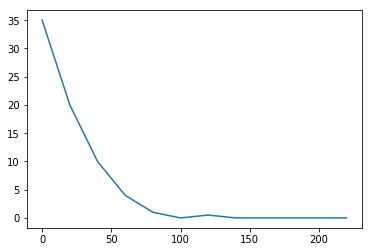

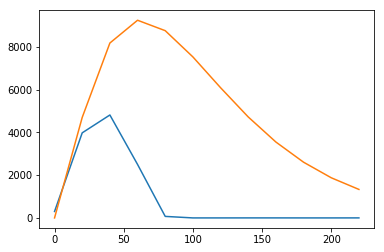

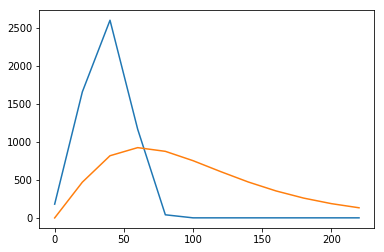

In [53]:
redshift = np.arange(0, len(binned), 20)
a = 1.5
b = 1.7
z0 = 0.7
r = (redshift/100)/z0
plt.plot(redshift, median_gal)
plt.show()
plt.plot(redshift, dist_clusters)
plt.plot(redshift, (50000)*(r**a)*(np.e**-r)**b)
plt.show()
plt.plot(redshift, dist_most_massive)
plt.plot(redshift, (5000)*(r**a)*(np.e**-r)**b)
plt.show()

In [54]:
print(median_gal)

[35.0, 20.0, 10.0, 4.0, 1.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
threshold = oversample*22*(median_gal[b]/220)
threshold = 2.5*median_gal[b]

In [62]:
print(redshift)
print(dist_clusters)
print(dist_most_massive)
print((r**a)*(np.e**-(r**b)))

[  0  20  40  60  80 100 120 140 160 180 200 220]
[301, 4007, 5502, 9236, 5750, 81, 0, 1, 1, 0, 0, 1]
[36, 202, 456, 796, 981, 54, 1, 1, 1, 1, 1, 1]
[0.         0.13560382 0.29356853 0.36762428 0.34835368 0.27288389
 0.18424046 0.10977869 0.05860413 0.02832307 0.01248728 0.00505182]


In [6]:
@dask.delayed
def mclusters(binned, binned_g, b):
    sample_real = binned[b]
    massive_sample = sample_real[sample_real.mass>11]
    if len(massive_sample)>0:
        massive_tree = spatial.cKDTree(massive_sample[["x", "y"]])
        sample = binned_g[b]
        tree = spatial.cKDTree(sample[["x", "y"]])
        
        r = 2
        neighbors = massive_tree.query_ball_tree(tree, r)
        counts = np.array([])
        for i in range(0, len(neighbors)):
            counts = np.append(counts, len(neighbors[i]))
        
        sample.reset_index(inplace=True)
        massive_sample.reset_index(inplace=True)
        massive_sample["neighbor_numbers"] = pd.Series(neighbors)
        massive_sample["neighbors"] = pd.Series(counts)
        
        masses = 10**sample.mass
        massive_sample["neighbor_mass"] = np.zeros(len(massive_sample))
        for i in range (0, len(massive_sample)):
            massive_sample["neighbor_mass"][i] = np.log10(np.sum(masses[massive_sample.neighbor_numbers[i]]))
        
        reds = sample.z_phot_median
        massive_sample["mean_red"] = np.zeros(len(massive_sample))
        for i in range (0, len(massive_sample)):
            massive_sample["mean_red"][i] = np.mean(reds[massive_sample.neighbor_numbers[i]])
        
        massive_sample["med_red"] = np.zeros(len(massive_sample))
        for i in range (0, len(massive_sample)):
            massive_sample["med_red"][i] = np.median(reds[massive_sample.neighbor_numbers[i]])
            
        C = 2.5
        threshold = C*np.median(counts)
        clusters = massive_sample[massive_sample.neighbors>threshold]
        
        if len(clusters)>0:
            cluster_tree = spatial.cKDTree(clusters[["x", "y"]])
            cluster_tree2 = spatial.cKDTree(clusters[["x", "y"]].copy())
            r = 2
            neighbors_c = cluster_tree.query_ball_tree(cluster_tree2, r)
            clusters.reset_index(inplace= True)
            clusters.drop(columns = ["neighbor_numbers"])
            clusters["neighbor_numbers"] = pd.Series(neighbors_c)
            
            clusters.sort_values("mass", inplace = True)
            clusters["ncluster"] = np.zeros(len(clusters))
            sample["ncluster"] = np.zeros(len(sample))
            clusternum = 1
            
            for index, gal in clusters.iterrows():
                if gal.ncluster == 0:
                    gal.ncluster = clusternum
                    for index2 in gal.neighbor_numbers:
                        if clusters.at[index2, "ncluster"] == 0:
                            clusters.at[index2, "ncluster"] = clusternum
                    clusternum+=1
            
            most_massive = clusters.sort_values(by = ['ncluster','mass'], ascending = False).groupby('ncluster').head(1)
        else:
            most_massive = pd.DataFrame([[]])
            
    else:
        clusters = pd.DataFrame([[]])
        most_massive = pd.DataFrame([[]])
    
    return clusters, most_massive

In [29]:
cluster_bins = []
cluster_gal_bins = []
delayed_results = []
pbar = display.ProgressBar(len(binned))
pbar.display()
for b in range(len(binned)):
    pbar.progress = b
    delayed_result = mclusters(binned, binned_g, b)
    delayed_results.append(delayed_result)


[=========================================================== ] 232/233

In [30]:
results = dask.compute(*delayed_results)

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:52718 remote=tcp://127.0.0.1:35779>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:52736 remote=tcp://127.0.0.1:35779>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:52750 remote=tcp://127.0.0.1:35779>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:52764 remote=tcp://127.0.0.1:35779>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:52786 remote=tcp://127.0.0.1:35779>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:52804 remote=tcp://127.0.0.1:35779>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:52816 remote=tcp://127.0.0.1:35779>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:52894 remote=tcp://127.0.0.1:35779>
distribu

KeyboardInterrupt: 

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:53394 remote=tcp://127.0.0.1:35779>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:53414 remote=tcp://127.0.0.1:35779>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:53448 remote=tcp://127.0.0.1:35779>
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [28]:
results[0]

(   level_0    index  z_phot_median  z_phot_std       mass  RELEASE  BRICKID  \
 0      206  4078472       0.103246    0.010970  11.063285     8000   313089   
 1      233  4439119       0.102134    0.006877  11.103098     8000   326070   
 2      243  4619208       0.108639    0.006397  11.162555     8000   326069   
 3      244  4619867       0.115188    0.006141  11.172151     8000   326069   
 5      253  4854956       0.101657    0.004845  11.378450     8000   324629   
 4      252  4853715       0.110743    0.003078  11.571613     8000   324629   
 
   BRICKNAME  OBJID  TYPE  ...     DEC_r           z          y          x  \
 0  0003m030     59  DEV   ... -0.054457  478.754476 -26.071725   3.324287   
 1  0056m007    943  DEV   ... -0.014685  478.754476  -7.030571  46.079623   
 2  0053m007    446  DEV   ... -0.014911  478.754476  -7.138849  45.386354   
 3  0053m007   1108  DEV   ... -0.014603  478.754476  -6.991178  44.442527   
 5  0053m010   7371  DEV   ... -0.015281  478.75

In [31]:
futures = []
pbar = display.ProgressBar(len(binned[:2]))
pbar.display()
for b in range(len(binned[:2])):
    pbar.progress = b
    parameters = (binned, binned_g, b)
    future = client.submit(mclusters, parameters)
    futures.append(future)

[==============================                              ] 1/2

In [44]:
def install():
    import os
    os.system("conda install pandas -c conda-forge -y")

client.run(install) 

{'tcp://127.0.0.1:33805': None,
 'tcp://127.0.0.1:35961': None,
 'tcp://127.0.0.1:36161': None,
 'tcp://127.0.0.1:38099': None,
 'tcp://127.0.0.1:38967': None,
 'tcp://127.0.0.1:42379': None,
 'tcp://127.0.0.1:45473': None,
 'tcp://127.0.0.1:46841': None}

In [4]:
client.get_versions(packages=['sklearn'])

{'scheduler': {'host': (('python', '3.7.3.final.0'),
   ('python-bits', 64),
   ('OS', 'Linux'),
   ('OS-release', '4.12.14-150.47-default'),
   ('machine', 'x86_64'),
   ('processor', 'x86_64'),
   ('byteorder', 'little'),
   ('LC_ALL', 'None'),
   ('LANG', 'C.UTF-8'),
   ('LOCALE', 'en_US.UTF-8')),
  'packages': {'required': (('dask', '2.8.0'),
    ('distributed', '2.8.0'),
    ('msgpack', '0.6.2'),
    ('cloudpickle', '1.2.2'),
    ('tornado', '6.0.3'),
    ('toolz', '0.10.0')),
   'optional': (('numpy', '1.17.3'),
    ('pandas', None),
    ('bokeh', '1.4.0'),
    ('lz4', None),
    ('dask_ml', None),
    ('blosc', None),
    ('sklearn', None))}},
 'workers': {'tcp://127.0.0.1:33805': {'host': (('python', '3.7.3.final.0'),
    ('python-bits', 64),
    ('OS', 'Linux'),
    ('OS-release', '4.12.14-150.47-default'),
    ('machine', 'x86_64'),
    ('processor', 'x86_64'),
    ('byteorder', 'little'),
    ('LC_ALL', 'None'),
    ('LANG', 'C.UTF-8'),
    ('LOCALE', 'en_US.UTF-8')),
   'pa

In [8]:
client.get_versions(check=True)

{'scheduler': {'host': (('python', '3.7.4.final.0'),
   ('python-bits', 64),
   ('OS', 'Linux'),
   ('OS-release', '4.12.14-150.47-default'),
   ('machine', 'x86_64'),
   ('processor', 'x86_64'),
   ('byteorder', 'little'),
   ('LC_ALL', 'None'),
   ('LANG', 'C.UTF-8'),
   ('LOCALE', 'en_US.UTF-8')),
  'packages': {'required': (('dask', '2.5.2'),
    ('distributed', '2.5.2'),
    ('msgpack', '0.6.1'),
    ('cloudpickle', '1.2.2'),
    ('tornado', '6.0.3'),
    ('toolz', '0.10.0')),
   'optional': (('numpy', '1.17.2'),
    ('pandas', '1.0.1'),
    ('bokeh', '1.3.4'),
    ('lz4', None),
    ('dask_ml', None),
    ('blosc', None))}},
 'workers': {'tcp://127.0.0.1:35425': {'host': (('python', '3.7.4.final.0'),
    ('python-bits', 64),
    ('OS', 'Linux'),
    ('OS-release', '4.12.14-150.47-default'),
    ('machine', 'x86_64'),
    ('processor', 'x86_64'),
    ('byteorder', 'little'),
    ('LC_ALL', 'None'),
    ('LANG', 'C.UTF-8'),
    ('LOCALE', 'en_US.UTF-8')),
   'packages': {'required'

In [32]:
futures[0]

<Future: status: error, key: mclusters-0eb7fe02f81de1bd3ab0af2e6f406aaf>

In [33]:
cluster_results, cluster_gal_results = client.gather(futures)

ModuleNotFoundError: No module named 'pandas'

In [9]:
import dask.dataframe as dd

/global/homes/m/mjyb16/.conda/envs/desi_dask/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [31]:
cluster.close()
client.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/global/homes/m/mjyb16/.conda/envs/desi_dask/lib/python3.7/site-packages/distributed/utils.py", line 662, in log_errors
    yield
  File "/global/homes/m/mjyb16/.conda/envs/desi_dask/lib/python3.7/site-packages/distributed/client.py", line 1284, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/global/homes/m/mjyb16/.conda/envs/desi_dask/lib/python3.7/site-packages/distributed/utils.py", line 662, in log_errors
    yield
  File "/global/homes/m/mjyb16/.conda/envs/desi_dask/lib/python3.7/site-packages/distributed/client.py", line 1013, in _reconnect
    await self._close()
  File "/global/homes/m/mjyb16/.conda/envs/desi_dask/lib/python3.7/site-packages/distributed/client.py", line 1